<a href="https://colab.research.google.com/github/Astra42/Deep-NN--DPO/blob/main/1_baseline_1_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Распознавание предметов одежды из набора MNIST

Импортируем необходимые библиотеки

In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

! kaggle competitions download nnfashinmnist
! unzip nnfashinmnist

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
mkdir: cannot create directory ‘/root/.kaggle’: File exists
nnfashinmnist.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  nnfashinmnist.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [ ]:
""" объект последовательной модели нейронной сети """
from tensorflow.keras.models import Sequential
""" полносвязный слой нейронной сети """
from tensorflow.keras.layers import Dense
""" функции для получения обратной связи во время обучения нейронной сети"""
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
""" вспомогательный модуль Keras для предварительной обработки данных """
from tensorflow.keras import utils
""" библиотекf для работы с матрицами (многомерными тензорами) и линейной алгеброй """
import numpy as np
""" библиотека для считывания и записи файлов в формате ".csv" и других табличных форматах,
    а также для их быстрой и удобной обработки """
import pandas as pd
""" библиотека для работы с операционной системой """
import os 

"""Зафиксируем генератор случайных чисел. Его не менять!!!"""
from numpy.random import seed
seed(2020)
from tensorflow.random import set_seed
set_seed(2020)
""" библиотека для визуализации данных """
import matplotlib.pyplot as plt
%matplotlib inline 
""" посмотрим, какие файлы храняться в директории """
for dirname, _, filenames in os.walk('/kaggle/input/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Загружаем наборы данных для обучения и тестирования

In [ ]:

"""функция "read_csv" презназначена для считывания файлов в формате ".csv"
filepath_or_buffer - путь к файлу,
index_col - необязательный параметр, который указывает какую колонку использовать, как индекс.
Если параметр не указан, что pandas создаст столбец с индексами самостоятельно
Подробнее о возможностях функции https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html"""
train_df = pd.read_csv(filepath_or_buffer='train.csv', index_col='id')
test_df = pd.read_csv(filepath_or_buffer='test.csv', index_col='id')
sample_submission = pd.read_csv(filepath_or_buffer='sample_submission.csv', index_col='id')

In [ ]:
sample_submission.head(10)

,label
id,
0,5
1,5
2,5
3,5
4,5
5,5
6,5
7,5
8,5


Извлекаем данные из таблиц pandas в числовые массивы (векторы и матрицы) numpy, которе можно подать на вход нейронной сети

In [ ]:
"""iloc позволяет считать необходимые строки и столбцы, обращаясь к ним не по именам, а по порядковой нумерации
Подробнее про функцию iloc https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.iloc.html
Запись train_df['label'], извлекает из всей таблицы столбец с названием 'label' 
.values - преобразовывает pandas DataFrame (объект таблицы) в numpy массив"""
x_train, y_train = train_df.iloc[:,:-1].values, train_df['label'].values
x_test = test_df.values

Проверяем совпадает ли количество признаков в тренировочном и тестовом наборах

In [ ]:
assert x_train.shape[1] == x_test.shape[1], 'Количество признаков в тренировочном и тестовом наборах должно совпадать'

Создаем соответствие номеров классов с их названиями

In [ ]:
classes = {0:'футболка', 1:'брюки', 2:'свитер', 3:'платье', 4:'пальто',
           5:'туфли', 6:'рубашка', 7:'кроссовки', 8:'сумка', 9:'ботинки'}

Смотрим примеры изображений в наборе

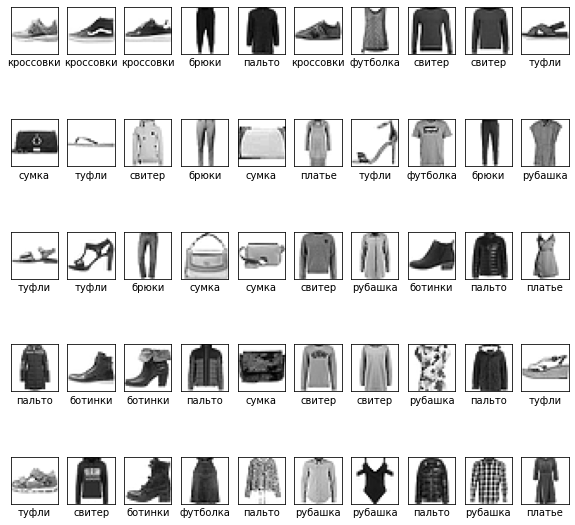

In [ ]:
plt.figure(figsize=(10,10))
for i in range(100,150):
    plt.subplot(5,10,i-100+1)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(x_train[i].reshape((28,28)), cmap=plt.cm.binary)
    plt.xlabel(classes[y_train[i]])

Нормализация данных

In [ ]:
# Векторизованные операции
# Применяются к каждому элементу массива отдельно
x_train = x_train / 255.0
# Все преобразования с тренировочным наборам повторяем и для тестового
x_test = x_test / 255.0

Работа с метками правильных ответов

In [ ]:
print(y_train[100])

7


**Преобразуем метки в формат one hot encoding**

In [ ]:
y_train = utils.to_categorical(y_train)

Правильный ответ в формате one hot encoding

In [ ]:
print(y_train[100])

[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


## Создаем нейронную сеть

**Описываем архитектуру нейронной сети**

In [ ]:
# Создаем последовательную модель
model = Sequential()
# Входной полносвязный слой, 800 нейронов, 784 входа в каждый нейрон
model.add(Dense(units=200, input_dim=784, activation="relu"))
model.add(Dense(units=200, activation="relu"))
model.add(Dense(units=200, activation="relu"))
# Выходной полносвязный слой, 10 нейронов (по количеству рукописных цифр)
model.add(Dense(units=10, activation="softmax"))

**Компилируем сеть**

In [ ]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 200)               157000    
                                                                 
 dense_12 (Dense)            (None, 200)               40200     
                                                                 
 dense_13 (Dense)            (None, 400)               80400     
                                                                 
 dense_14 (Dense)            (None, 10)                4010      
                                                                 
Total params: 281,610
Trainable params: 281,610
Non-trainable params: 0
_________________________________________________________________
None


## Обучаем нейронную сеть[](http://)

Обычный подход

In [ ]:
model.fit(x_train, y_train, 
          batch_size=150, 
          epochs=30,  
          verbose=1)

Epoch 1/30
439/439 [==============================] - 5s 11ms/step - loss: 0.1072 - accuracy: 0.9574
Epoch 2/30
439/439 [==============================] - 5s 10ms/step - loss: 0.1009 - accuracy: 0.9605
Epoch 3/30
439/439 [==============================] - 4s 10ms/step - loss: 0.1000 - accuracy: 0.9612
Epoch 4/30
439/439 [==============================] - 5s 10ms/step - loss: 0.0944 - accuracy: 0.9630
Epoch 5/30
439/439 [==============================] - 5s 10ms/step - loss: 0.0956 - accuracy: 0.9625
Epoch 6/30
439/439 [==============================] - 4s 10ms/step - loss: 0.0866 - accuracy: 0.9659
Epoch 7/30
439/439 [==============================] - 5s 10ms/step - loss: 0.0867 - accuracy: 0.9659
Epoch 8/30
439/439 [==============================] - 4s 10ms/step - loss: 0.0831 - accuracy: 0.9677
Epoch 9/30
439/439 [==============================] - 5s 10ms/step - loss: 0.0812 - accuracy: 0.9686
Epoch 10/30
439/439 [==============================] - 5s 11ms/step - loss: 0.0791 - accura

## Подход с применением обратной связи

В процессе обучения нейронной сети, мы можем следить за изменением ее показателей и как-то реагировать на эту обратную связь.
Например, если мы видим, что нейронная сеть уже 5 эпох подряд не улучшает свой результат (loss не уменьшается или accuracy не растет), то возможно нет смысла учиться дальше и мы хотели бы остановить процесс обучения. Но нейронная сеть учиться столько эпох, сколько мы указали.
### Чтобы избежать такого лишнего обучения, можно использовать метод **EarlyStopping** (ранний останов).
* С помощью параметра **monitor** она следит за указанной величиной: loss или accuracy.
* С помощью параметра **patience** мы указываем через сколько эпох обучения без улучшения мы хотим прекратить процесс обучения. Таким образом мы можем избежать траты лишних ресурсов и времени
* С помощью параметра **restore_best_weights=True** можно сохранить лучшие веса модели, а не последние.

Может оказаться, что на более ранней эпохе у модели было лучшее качество, чем на более поздней эпохе. Но сейчас мы получаем модель с весами, обученными на последней эпохе.
### Чтобы сохранить самую лучшую модель, можно использовать ModelCheckpoint
* filepath - путь для сохранения лучшей модели
* monitor - параметр, за которым мы будем следить: loss, accuracy
* save_best_only=True - говорит о том, что мы хотим сохранить лишь лучшую модель

In [ ]:
"""Если вы хотите применить подход с обратной связью,
    то снимите комментарии со следующего кода.
    Попробуйте менять параметры monitor и patience"""
# # Создаем последовательную модель
# model = Sequential()
# # Входной полносвязный слой, 800 нейронов, 784 входа в каждый нейрон
# model.add(Dense(units=800, input_dim=784, activation="relu"))
# # Выходной полносвязный слой, 10 нейронов (по количеству рукописных цифр)
# model.add(Dense(units=10, activation="softmax"))
# # компилируем модель
# model.compile(loss="categorical_crossentropy", optimizer="SGD", metrics=["accuracy"])
# print(model.summary())
# # создаем лист с обратными связями
# # в случае restore_best_weights=True, применять  ModelCheckpoint не нужно
# callbacks_list = [EarlyStopping(monitor='loss', patience=5, restore_best_weights=True),
#                   ModelCheckpoint(filepath='my_model.h5',
#                                   monitor='loss',
#                                   save_best_only=True),
#                  ]
# # добавляем лист с обратными связями в параметр callbacks
# model.fit(x_train, y_train,
#             batch_size=200,
#             epochs=10,
#             callbacks=callbacks_list,
#             verbose=1)

'Если вы хотите применить подход с обратной связью,\n    то снимите комментарии со следующего кода.\n    Попробуйте менять параметры monitor и patience'

## Используем сеть для распознавания моделей одежды

**Запускаем распознавание набора данных, на котором обучалась сеть**

In [ ]:
predictions = model.predict(x_train)

2057/2057 [==============================] - 6s 3ms/step


**Проверяем качество распознавания**

Просматриваем пример изображения

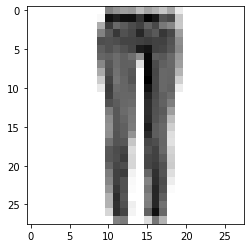

In [ ]:
# Меняйте значение n чтобы просмотреть результаты распознавания других изображений
n = 2022
plt.imshow(x_train[n].reshape(28, 28), cmap=plt.cm.binary)
plt.show()

Данные на выходе из сети в формате one-hot-encoding

In [ ]:
print(predictions[n])

[2.6371196e-32 9.9999994e-01 4.7150548e-33 9.4332961e-26 0.0000000e+00
 2.5471129e-35 9.2728937e-32 1.5023975e-38 4.1626397e-26 7.9152547e-27]


Определяем номер класса изображения, который предлагает сеть

In [ ]:
"""argmax - находит максимальный элемент массива и возвращает его номер в массиве"""
np.argmax(predictions[n])

1

Печатаем название класса

In [ ]:
"""Передаем в словарь classes номер максимального элемента предсказанного сетью
Словарь возвращает название класса, который скрыт за этим номером"""
classes[np.argmax(predictions[n])]

'брюки'

Печатаем номер класса правильного ответа

In [ ]:
np.argmax(y_train[n])

1

Печатаем название класса правильного ответа

In [ ]:
classes[np.argmax(y_train[n])]

'брюки'

## Готовим данные для теста на liderboard

Распознаем тестовый набор данных

In [ ]:
"""делаем предсказания по всем тестовым данным"""
predictions = model.predict(x_test)
"""извлекаем номера предсказаний с максимальными вероятностями по всем объектам тестового набора"""
predictions = np.argmax(predictions, axis=1)
predictions

132/132 [==============================] - 0s 3ms/step


array([0, 2, 7, ..., 6, 0, 5])

Пишем результаты предсказаний в шаблон "sample_submission"

In [ ]:
"""используем файл с правильным шаблоном формата записи ответов и пишем в него наши предсказания"""
sample_submission['label'] = predictions

Записываем ответы для проверки на liderboard

In [ ]:
"""to_csv - пишет табличные данные в файл '.csv' """
sample_submission.to_csv('sample_submission.csv')